# AnimeGM - CNN
GOAL: Generate new anime-style images
    
Methodology:
1. Build a dataset of images suitable for out needs. There should be at least 1000 images of the same size 28x28?
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Apply the this model to a real image
6. Examine results

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

In [1]:
import pandas as pd
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from skimage.transform import resize
from os import listdir
from os.path import join
from skimage import data
%matplotlib inline

In [2]:
def gray_scale_resize(image, reshape_dim):
    # convert image to grayscale
    # same computation while we experiment
    gray_image = color.rgb2gray(image)
    
    # Resize the image down to 128x128
    resized_image = resize(gray_image, (reshape_dim, reshape_dim))
    
    return resized_image

In [3]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [4]:
def load_images(paths_list, n_images, reshape_dim):
    # slice paths list to the amount we want
    slice_paths_list = paths_list[:n_images]

    # create an array for images
    images = np.zeros((n_images, reshape_dim, reshape_dim), dtype=np.float32)
        
    for i, image_path in enumerate(slice_paths_list): 
        # read image
        image = misc.imread(join(path, image_path))

        # rescale image
        images[i] = gray_scale_resize(image, reshape_dim)
        
    return images

In [5]:
def plot_image(images, figsize=(10, 10)):
    # get the number of images
    n_images = images.shape[0]
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i >= n_images:
            return
        im = axi.imshow(images[i], cmap='gray')

In [6]:
# base path
path = 'danbooru-small'

# list of img paths
paths_list = listdir(path)

# number of image to use in dataset
n_images = 50

# number of pixels to resize image to
reshape_dim = 64

In [7]:
# load images
images = load_images(paths_list, n_images, reshape_dim)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: U

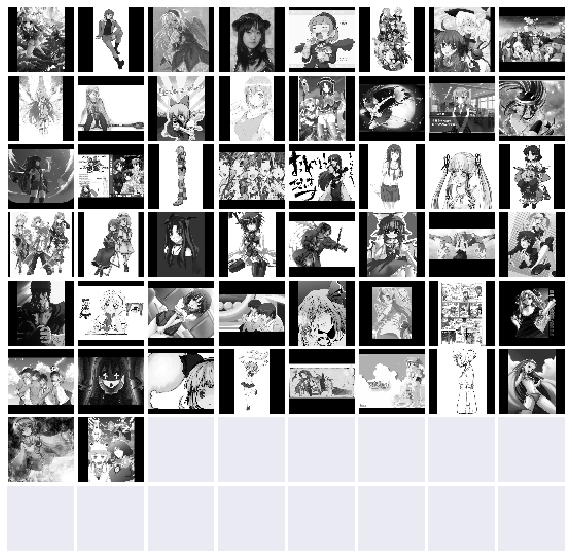

In [8]:
# plot the images of the dataset
plot_image(images)

This generative model will also substract the mean image from the dataset so lets get that

## 2. Build a generative model
Lets build an autoencoder

In [9]:
import tensorflow as tf

In [10]:
# dimensions list describing n_output at each layer
dimensions = [2048, 1024, 512]

In [11]:
# number of features
n_features = reshape_dim * reshape_dim

# reshape images 
reshaped_images = images.reshape(-1, n_features)

In [12]:
mean_image = np.mean(reshaped_images, axis=0)

In [13]:
mean_image_reshaped = mean_image.reshape(reshape_dim, reshape_dim)

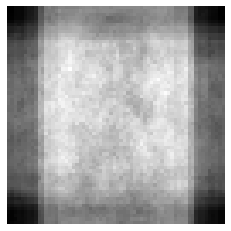

In [14]:
show_image(mean_image_reshaped)

In [15]:
# create a place holder for inputs
X = tf.placeholder(tf.float32, [None, n_features])

Build the first half of the autoencoder which reduces dimensions at each layer

In [16]:
# copy X placeholder to current_input
current_input = X
n_input = n_features

# create a list to store each matrix created
Ws = []

# loop over the list of dimensions and create a layer
# layer_i = index of current element
# n_output = element
for layer_i, n_output in enumerate(dimensions):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        
        # create a weight matrix of the shape [n_input, n_output]
        W = tf.get_variable(
                name='W',
                shape=[n_input, n_output],
                initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        
        # create bais vector of the shape [n_output]
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
        
        # multiply the layer input and the weight matrix
        # and add the bais
        h = tf.nn.bias_add(
                name='h',
                value=tf.matmul(current_input, W),
                bias=b)
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)
        
        # store the weight matrix so that we can build the decoder
        Ws.append(W)
        
        # update the input dimensions with the current layer output
        n_input = n_output

At this point, we have the first half of the convolutional autoencoder. the input to the second half is at it's smallest dimensions.

This means it should be the size of the last element of the dimensions list

In [17]:
print(current_input.get_shape())
print(dimensions[-1])

(?, 512)
512


Build the next half of the convolutional autoencoder by increasing the dimensions at each layer back to the original

In [18]:
# reverse the order of the weight matrices
Ws = Ws[::-1]

# reverse the order of the dimensions
# append on the original dimension on the end of the list
dimensions = dimensions[::-1][1:] + [n_features]

print(Ws)
print(dimensions)

[<tf.Variable 'encoder/layer/2/W:0' shape=(1024, 512) dtype=float32_ref>, <tf.Variable 'encoder/layer/1/W:0' shape=(2048, 1024) dtype=float32_ref>, <tf.Variable 'encoder/layer/0/W:0' shape=(4096, 2048) dtype=float32_ref>]
[1024, 2048, 4096]


In [19]:
# loop over the list of dimensions and create a layer
# layer_i = index of current element
# n_output = element
for layer_i, n_output in enumerate(dimensions):
    # use variable scope to encapsulate variables
    # prefix all variables created in this scope
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        
        # grab the weight matrix fron the encoder and transpose it
        W = tf.transpose(Ws[layer_i])
        
        # create bais vector of the shape [n_output]
        b = tf.get_variable(
                name='b',
                shape=[n_output],
                dtype=tf.float32,
                initializer=tf.constant_initializer(0.0))
        
        # multiply the layer input and the weight matrix
        # and add the bais
        h = tf.nn.bias_add(
                name='h',
                value=tf.matmul(current_input, W),
                bias=b)
        
        # use an activation function (RELU) on the output and set it to the input for the next layer
        current_input = tf.nn.relu(h)
        
        # update the input dimensions with the current layer output
        n_input = n_output

the current_input of the last layer is Y

In [20]:
Y = current_input

Define the training signal.
This will be a cost function to measure the success of the network

In [21]:
# measure average difference across pixels
pixel_cost = tf.reduce_mean(tf.squared_difference(X, Y), 1)

# measure mean across batches
cost = tf.reduce_mean(pixel_cost)

In [22]:
# use an Adam optimizer for training which tries to minimize cost
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## 3. Train the model

In [23]:
# create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [33]:
batch_size = 5
n_batches = int(n_images / 5)
n_epochs = 5
examples = reshaped_images[:10]

In [ ]:
fig, ax = plt.subplots(1, 1)
for epoch_i in range(n_epochs):
    for batch_i in range(n_batches):
        # get batch
        batch_start = batch_i * batch_size
        batch_end = batch_start + batch_size
        batch_X = reshaped_images[batch_start:batch_end]
        
        # train
        sess.run(optimizer, feed_dict={X: batch_X - mean_image})

        # reconstruct the example images
        reconstructed_images = sess.run(Y, feed_dict={X: examples - mean_image})

        # reshape them to the original shape and type
        reconstructed_images_reshaped = (reconstructed_images + mean_image).reshape(-1, reshape_dim, reshape_dim)

        # plot them
        plot_image(reconstructed_images_reshaped)

        # show cost per epoch
        print(epoch_i, sess.run(cost, feed_dict={X: batch_X - mean_image}))

0 0.0956634


## 4. Generate a new image
Use the trained model to generate a new image

In [43]:
n_new_images = 2

In [44]:
np.random.RandomState(seed=0)
images_new = np.random.rand(n_new_images, reshape_dim, reshape_dim)

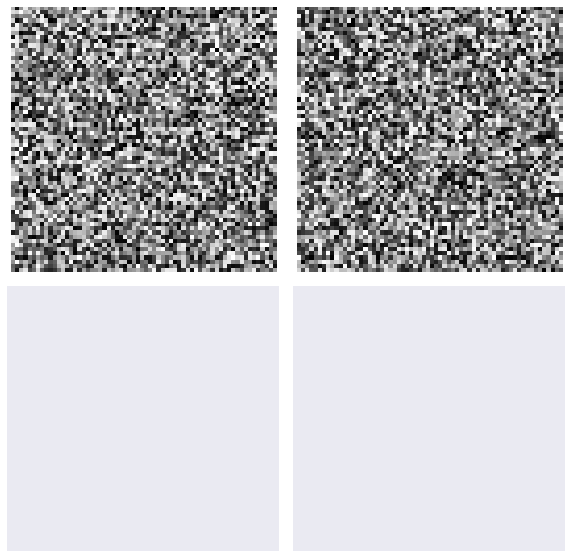

In [45]:
plot_image(images_new)

In [48]:
images_new_reshaped = images_new.reshape(-1, n_features)

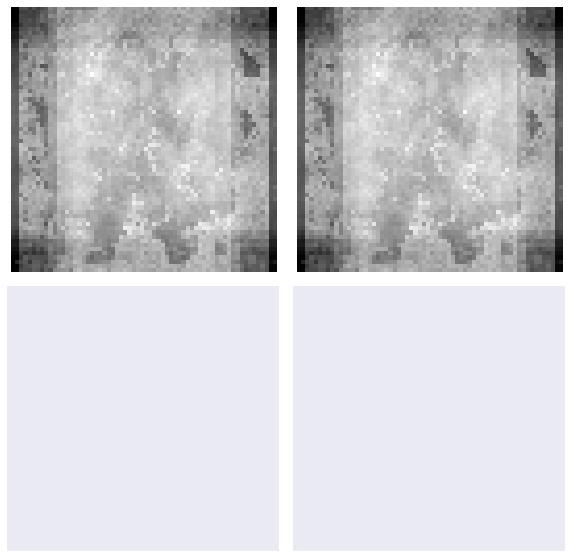

In [71]:
# reconstruct the example images
reconstructed_images = sess.run(Y, feed_dict={X: images_new_reshaped - mean_image})

# reshape them to the original shape and type
reconstructed_images_reshaped = (reconstructed_images + mean_image).reshape(-1, reshape_dim, reshape_dim)

# plot them
plot_image(reconstructed_images_reshaped)

## 5. Apply model to a real image

In [57]:
# grab an image
test_image = data.astronaut()

In [58]:
resized_test_image = gray_scale_resize(test_image, reshape_dim)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


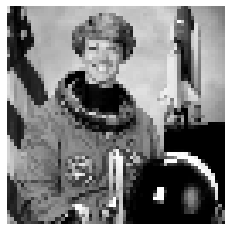

In [59]:
# display an image
show_image(resized_test_image)

In [66]:
test_image_reshaped = resized_test_image.reshape(-1, n_features)

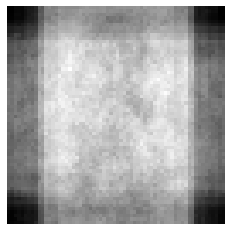

In [72]:
# reconstruct the example images
reconstructed_test_image = sess.run(Y, feed_dict={X: test_image_reshaped - mean_image})

# reshape them to the original shape and type
reconstructed_test_image_reshaped = (reconstructed_test_image + mean_image).reshape(reshape_dim, reshape_dim)

# plot them
show_image(reconstructed_test_image_reshaped)

## 6. Examine results